<hr>
<h1><center>Climate Change Belief Analysis Competition</center></h1>
<hr>

## Table of Contents

1. [Introduction](#the_intro)

1. [Data Overview](#the_data)
 
1. [Connecting to Comet](#the_connection)
 
1. [Importing the libraries](#the_libraries)
 
1. [Loading the Datasets](#the_load)

1. [Inspecting the Data](#inspecting)
 
1. [Text PreProcessing](#the_prep)

1. [Exploratory data analysis](#the_analysis)
 
1. [Feature to Text (Feature Engineering on text)](#the_features)
 
1. [Modelling before Resampling](#the_fit)

1. [Modelling before Resampling](#the_balancedfit)

1. [Hyperparameter Tuning](#the_tune)

1. [Evaluate Model](#the_eval)
 
1. [Saving the model](#the_saving)

1. [Logging to Comet](#the_logging)

1. [Conclusions](#the_conclusion)


<a id='the_intro'></a>
## Introduction

### Problem Identification

Many companies are built around lessening one’s environmental impact or carbon footprint. They offer products and services that are environmentally friendly and sustainable, in line with their values and ideals. They would like to determine how people perceive climate change and whether or not they believe it is a real threat. This would add to their market research efforts in gauging how their product/service may be received.


Providing an accurate and robust solution to this project gives companies access to a broad base of consumer sentiment, spanning multiple demographic and geographic categories - thus increasing their insights and informing future marketing strategies.


### Problem Statement

The purpose of this project is to train a Classification model to predict the sentiment of tweets related to climate change.

The Machine Learning model chosen will be the one with the highest `Weighted F1-score `(the performance metric used to evaluate the models). 

Click [here](https://www.kaggle.com/c/climate-change-belief-analysis/overview) to view the competition page.

<a id='the_data'></a>
## Data Overview

The collection of this data was funded by a Canada Foundation for Innovation JELF Grant to Chris Bauch, University of Waterloo. The dataset aggregates tweets pertaining to climate change collected between Apr 27, 2015 and Feb 21, 2018. In total, 43943 tweets were collected.

The training and test datasets provided here is a subset of these 43943 tweets.

The files to be downloaded are:
* **Train.csv** - the dataset for training our model.
* **Test.csv** - the dataset for testing our model .

Variable definitions on the train dataset:

`sentiment`: Sentiment of tweet

`message`: Tweet body

`tweetid`: Twitter unique id

Each tweet is labelled as one of the following sentiment classes:

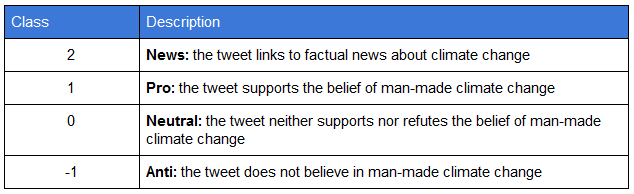

<a id='the_connection'></a>
## Connecting to Comet

Comet is a platform that allows data scientists and developers to easily monitor, compare and optimize their machine learning models. 
More information about Comet can be found [here](https://techcrunch.com/2018/04/05/cometml-wants-to-do-for-machine-learning-what-github-did-for-code/#:~:text=Comet.ml%20allows%20data%20scientists,optimize%20their%20machine%20learning%20models.&text=The%20service%20provides%20you%20with,ML).  

Firstly, `comet_ml` has to be installed.


In [ ]:
!pip install comet_ml

In [ ]:
import comet_ml
from comet_ml import Experiment

#Setting up the API KEY
experiment = Experiment(api_key= 'p0xSNBixchjaLhMutKMYVuJAq',project_name="classification_team_1_jhb",workspace="crtshabangu")

<a id='the_libraries'></a>
## Importing the libraries

Before proceeding with importing the usual libraries, there are some natural language processing libraries that need to be installed: 

* `spacy`
* `wordcloud`
* `nltk`



In [ ]:
!pip install spacy
!pip install wordcloud
!pip install nltk

In [ ]:
#standard libraries
import numpy as np
import pandas as pd

#visualization
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud

#modeling libraries
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC,SVC
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,confusion_matrix
from sklearn.utils import resample

#text processing libraries
import re
import spacy
nlp = spacy.load('en_core_web_sm')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import TreebankWordTokenizer, SnowballStemmer
from nltk.stem import WordNetLemmatizer
#nltk.download('stopwords')
import string

#pickling
import pickle

<a id='the_load'></a>
## Loading the Datasets

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
train_data = pd.read_csv('/kaggle/input/climate-change-belief-analysis/train.csv')
test_data = pd.read_csv('/kaggle/input/climate-change-belief-analysis/test.csv')

<a id='inspecting'></a>
## Inspecting the Data

In [ ]:
train_data.head()

In [ ]:
test_data.head()

In [ ]:
len(train_data), len(test_data)

The training set has 15819 tweets.

The testing set has 10546 tweets. 

For ease, the `tweetid` column is set to be the index. 

In [ ]:
train_data.set_index('tweetid', inplace=True)
test_data.set_index('tweetid', inplace=True)

Checking for missing data:

In [ ]:
train_data.isnull().sum()

In [ ]:
test_data.isnull().sum()

Checking for empty strings:

In [ ]:
blanks = []  # start with an empty list

for i,lb,tw in train_data.itertuples():  # iterate over the DataFrame
    if type(tw)==str:                    # avoid NaN values
        if tw.isspace():                 # test 'review' for whitespace
            blanks.append(i)             # add matching index numbers to the list
        
print(len(blanks), 'blanks in train data: ', blanks)   # Checking for empty strings

In [ ]:
blanks = []  # start with an empty list

for i, tw in test_data.iterrows():  # iterate over the DataFrame
    if type(tw)==str:            # avoid NaN values
        if tw.isspace():         # test 'review' for whitespace
            blanks.append(i)     # add matching index numbers to the list
        
print(len(blanks), 'blanks in test data: ', blanks)

Th data has no missing values, and no empty tweet strings.

<a id='the_prep'></a>
## Text PreProcessing

In classification, the process of cleaning and standardization of text and making it noise-free is known as **text preprocessing**. This entails of:
* Noise Removal.
* Object Standardization.
* Lexicon Normalization.


### **Noise Removal**

Any piece of information (text) that is not relevant in the data is considered as noise. The following constitutes as noise: stop words, urls, links, social media entities, punctuations or any industry-specific words. Noise is to be removed from our data as it is not required.
 
**NB**: Part of noise removal in this instance involves **Object Standardization**. Object Standardization involves making sense of, or removing words or phrases which are not present in any standard lexical dictionaries. These pieces are not recognized by search engines and models. Some examples include acronyms, hashtags with attached words, and colloquial slangs.

In [ ]:
#Converting every tweet to be lower case
train_data['message'] = train_data['message'].str.lower()
test_data['message'] = test_data['message'].str.lower()

Here, unexpected artifacts, urls, twitter handles and numbers in the tweets are removed. 

In [ ]:
def cleaning(text):
    
    """
    Function takes in a text, and returns it cleaned of all noise 
    (such as  unexpected artifacts, urls, twitter handles and numbers).
    
    """
    
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@[\w]*','',text)
    text = re.sub(r'â€¦', '', text)
    text = re.sub(r'…', '', text)
    text = re.sub(r'â€™', "'", text)
    text = re.sub(r'â€˜', "'", text)
    text = re.sub(r'\$q\$', "'", text)
    text = re.sub(r'&amp;', "and", text)
    text = re.sub('[0-9]+', '', text)
    
    words = text.split()  
    
    return( " ".join(words))


In [ ]:
train_data['message'] = train_data['message'].apply(cleaning)
test_data['message'] = test_data['message'].apply(cleaning)

Python's `string` library is used to remove punctuation.

In [ ]:
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', string.punctuation))

In [ ]:
train_data['message'] = train_data['message'].apply(remove_punctuation)
test_data['message'] = test_data['message'].apply(remove_punctuation)

It is noticed that the tweets contain 'rt', implying a retweet.

Hence, 'rt', 'rts' and 'retweet' are added as stopwords, and all stopwords are now removed. 

In [ ]:
#Remove Stop words
def stop(text):
    
    """" 
    Function takes in some text, adds the variants of 'retweets'
    into the stopwords list, and then removes all stopwords.
    
    """
    
    word = text.split()
    #Remove stop words
    stop_additional = ['rt','rts', 'retweet']
    stop_word = set().union(stopwords.words('english'), stop_additional)
    remove_stop = [w for w in word if w not in stop_word]
    free_stop = " ".join(remove_stop)
    
    return free_stop 


In [ ]:
train_data['message'] = train_data['message'].apply(stop)
test_data['message'] = test_data['message'].apply(stop)

### Lexicon Normalization 

Another type of textual noise to be removed include multiple representations exhibited by a single word.

The common types of Lexicon Normalization:


* **Stemming**:  Stemming is a rudimentary rule-based process of stripping the suffixes (“ing”, “ly”, “es”, “s”, etc) from a word.
* **Lemmatization**: Lemmatization, on the other hand, is an organized, and step-by-step procedure of obtaining the root form of the word, by making use of vocabulary (dictionary importance of words) and morphological analysis (word structure and grammar relations).

In this case, lemmatization is chosen. In lemmatization, words like "loving", "lovely" and "loved" are normalized to their root-word "love".
This process returns words present in our dictionary; unlike stemming which may return words that may not even exist. 




In [ ]:
def lemmatizer(text):
    
    """" 
    Function takes in some text, and returns the lemmatized text.
    
    """
    
    lemma = WordNetLemmatizer()
    new_text = " ".join([lemma.lemmatize(lem) for lem in text.split()])
    
    return new_text


In [ ]:
train_data['message'] = train_data['message'].apply(lemmatizer)
test_data['message'] = test_data['message'].apply(lemmatizer)

In [ ]:
train_data.head()

In [ ]:
test_data.head()

<a id='the_analysis'></a>
## Explanatory Data Analysis

### Distribution of the classes

In [ ]:
# Separate the classes
news = train_data[train_data['sentiment']==2]
pro = train_data[train_data['sentiment']==1]
neutral = train_data[train_data['sentiment']==0]
anti = train_data[train_data['sentiment']==-1]

In [ ]:
# Get all possible labels
labels = train_data['sentiment'].unique()
heights = [len(pro),len(news),len(neutral),len(anti)]
plt.bar(labels,heights,color='blue')
plt.xticks(labels,['pro','news', 'neutral', 'anti'])
plt.xlabel('sentiments')
plt.ylabel("number of observations")
plt.title('Distribution of classes')
experiment.log_figure(figure=plt,figure_name='Bar plot showing distribution of classes')
plt.show()

Many of the tweets are from people who believe in man-made climate change. Unresolved class imbalance can lead to the classifier been good at predicting the class(es) with the majority of the data points in the dataset. Whether class imbalance results in poor performance or not is something that needs to be tested. 

The exact percentages of these classes are now inspected using a pie chart.

In [ ]:
plt.figure(figsize=(7,7))
train_data["sentiment"].value_counts().plot.pie(labels=['Pro', 'News', 'Neutral', 'Anti'], 
                                                autopct='%.1f%%',
                                                title = 'Pie chart showing percentage of class distribution',
                                                colors = ['grey','lime','brown','blue'])
experiment.log_figure(figure=plt,figure_name='Pie chart showing percentages of class distridution')

More that 50% of the tweets belong to the `pro` class. Recall that the `pro` class represent tweets of people who believe in man-made climate change. This could be an indication that people are finally acknowledging this phenomenon, and more people are becoming aware of it. 

### Length of tweets per class

In [ ]:

fig, axs = plt.subplots(2, 2, figsize=(11,7))

axs[0, 0].hist(pro.message.str.len(),bins=50,label='pro',color='grey')
axs[0, 0].set_title('pro')

axs[1, 0].set_title('news')
axs[1, 0].hist(news.message.str.len(),bins=50,label='news',color='lime')

axs[0, 1].set_title('neutral')
axs[0, 1].hist(neutral.message.str.len(),bins=50,label='neutral',color='brown')

axs[1, 1].set_title('anti')
axs[1, 1].hist(anti.message.str.len(),bins=50,label='anti',color='blue')

for ax in axs.flat:
    ax.set(xlabel='length of tweets', ylabel='number of tweets')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

experiment.log_figure(figure=plt,figure_name='histograms showing the count of length of tweets')     

It seems like the length for most tweets lie in the `20-120` range in all classes. 

### Wordclouds: Visualizing frequently used words in the tweets

A **word cloud** is a technique used in visualization to represent text data in such a way that the size of each word in the text indicate its significance or occurrances. Words that are largely displayed have a high frequency in the text.

#### WordCloud 1: Top 50 Words

In [ ]:
all_words = ''.join([label for label in train_data['message']])

In [ ]:
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, max_words=50).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 50 Words')
experiment.log_figure(figure=plt,figure_name='Wordcloud for top 50 Words')
plt.show()

This visual depicts the 50 most common words in the
 dataset. 
* Words like "climate change", "global warming" and "science" are included.

#### WordCloud2: Top 50 Words in "Pro" Tweets

In [ ]:
pro_tweets = train_data[train_data['sentiment'] == 1]
all_words = ''.join([label for label in pro_tweets['message']])

In [ ]:
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, max_words=50).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 50 Words in Pro Tweets')
experiment.log_figure(figure=plt,figure_name='Wordcloud for top 50 Words in Pro Tweets')
plt.show()

This visual depicts the 50 most common words among `pro` tweets.

* Words like "change denier", "tackle climate" and "going die" are included.

#### WordCloud3: Top 50 Words in "Anti" Tweets

In [ ]:
anti_tweets = train_data[train_data['sentiment'] == -1]
all_words = ''.join([label for label in anti_tweets['message']])

In [ ]:
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, max_words=50).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 50 Words in Anti Tweets')
experiment.log_figure(figure=plt,figure_name='Wordcloud for top 50 Words in Anti Tweets')
plt.show()

This visual depicts the 50 most common words among `anti` tweets.

* Words like "chinese", "man made" and "trump" are included.

#### WordCloud4: Top 50 Words in "Neutral" Tweets

In [ ]:
neutral_tweets = train_data[train_data['sentiment'] == 0]
all_words = ''.join([label for label in neutral_tweets['message']])

In [ ]:
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, max_words=50).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 50 Words in Neutral Tweets')
experiment.log_figure(figure=plt,figure_name='Wordcloud for top 50 Words in Neutral Tweets')
plt.show()

This visual depicts the 50 most common words among `neutral` tweets.

Words like "warming", "global" and "club penguin" are included.

####  WordCloud5: Top 50 Words in "News" Tweets

In [ ]:
news_tweets = train_data[train_data['sentiment'] == 2]
all_words = ''.join([label for label in news_tweets['message']])

In [ ]:
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, max_words=50).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 50 Words in News Tweets')
experiment.log_figure(figure=plt,figure_name='Wordcloud for top 50 Words in News Tweets')
plt.show()

This visual depicts the 50 most common words among `news` tweets.

Words like "paris agreement", "scott pruitt" and "carbon dioxide" are included.

<a id='the_features'></a>
## Text to Features (Feature Engineering on text data)

Feature engineering on text data simply means extracting features from text using the following techniques:

* **Bag of Words** <br>
This extracts features from text and counts the frequency of words in a document (the simplest form). 
<br>
*  **TF-IDF** <br>
Tfidf combines **Term Frequency (TF)** and **Inverse Document Frequency** (IDF). It computes the term frequency-inverse document value for each word. TF is the raw count of a term in a document. IDF is an algorithm that reduces the weight for most common words and add more weight for words that are rare in a document. We compute these two as follows:
  * TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document)
  * IDF(t) = log_e(Total number of documents / Number of documents with term t in it) 
  <br>

* **Word2Vec** <br>
This is a two layer neutral-net that processes text.



Firstly, the data has to be split into labels and features. 

### Obtaining X and y

In [ ]:
X = train_data['message']
y = train_data['sentiment'].values


### Split the data into train & test sets

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)


### Applying Tfidf

We now apply scikit-learn's `TfidfVectorizer` which does the following to our text data:

*   It counts all the occurrences of the unique words and transforms the tweets to feature vectors
*   A refinement on top of counting the words is to downscale the weight for words that occur in many tweets (such as "the") and are therefore less informative than those that occur only in a few tweets (such as "climate").
*   This is achieved by simply dividing the number of occurrences of each word in the tweets by the total number of words in the tweets.


In [ ]:
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_train_tfidf.shape

Note the shape of `X_train_tfidf`, which indicates the number of features in the feature vector.

<a id='the_fit'></a>
## Modelling before Resampling


### Fit Model

#### Models to Fit:

1. **Logistic Regression**
   * Logistic Regression models the probability that `Y`(label) belongs to a certain category (or class). It uses the logistic       function to fit the model using a method called the **maximum likelihood**. It produces an `S-shaped` curve. This model         can be extended to **Multi-class classification**, where we combine multiple logistic models using an approach called           `one-vs-rest`.
<br>   


2. **Support Vector Classifier**
   * 
<br> 

 
3. **K-Nearest Neighbors (KNN)**
   * KNN is an easy and powerful machine learning algorithm. The algorithm works by assigning the majority class of the N            closest neighbors to the current data point. Hence, no training is required for the algorithm, the only thing we do is          choose `k` (i.e. the number of neighbors to consider) and choose the `Euclidean distance function` to calculate proximity.<br>
   
   
4. **Neural Networks** 
    * ???????????

     
   

Remember that only the training set has been vectorized into a full vocabulary. In order to perform an analysis on the test set, it has to be submitted to the same procedures. Hence, the `Pipeline` class is used. .


In [ ]:
def fit_evaluate_model(model,X_train, y_train):
    
    """" 
    Function takes a model to train as input, and returns the performance
    of said model (in the form of various metrics). 
    
    """
    
    text_clf = Pipeline([('tfidf', TfidfVectorizer()),
                         ('clf',model)])
    
    # Fit the model to the training set
    text_clf.fit(X_train, y_train) 
    
    # Obtain predictions on the validation set
    y_pred = text_clf.predict(X_train)
    y_pred_test=text_clf.predict(X_test)
    
    # Determining the performance of the model
    accuracy = accuracy_score(y_train,y_pred)
    precision = precision_score(y_train,y_pred,average='weighted')
    recall = recall_score(y_train,y_pred,average='weighted')
    f1 = f1_score(y_train,y_pred,average='weighted')
    f1_test = f1_score(y_test,y_pred_test,average='weighted')
    
    # Create dictionary for metrics
    performance = {"accuracy": accuracy,"precision":precision,
                   "recall":recall,"f1":f1,"f1_test":f1_test}
    
    output = pd.DataFrame([performance])

 
    return output
    

#### Model 1 : Logistic Regression

In [ ]:
model1 = LogisticRegression(C=8.0,multi_class='ovr',max_iter=10000)
logistic_model = fit_evaluate_model(model1,X_train,y_train)


#### Model 2: Linear SVM model

In [ ]:
model2 = LinearSVC()
linear_svc = fit_evaluate_model(model2,X_train,y_train)

#### Model 3 : Kernel SVM Model

In [ ]:
model3=SVC(kernel = 'rbf')
kernel_svc = fit_evaluate_model(model3,X_train,y_train)

#### Model 4 : Naive Bayes

In [ ]:
fit_evaluate_model(MultinomialNB())

#### Assess accuracy

In [ ]:
assess = pd.concat([logistic_model,linear_svc,kernel_svc])
assess.index = ['Logistic Regression','Linear SVM Model','Kernel SVM Model']
assess

Since our data is imbalanced.The accuracy metric we use is the `f1_score`. The imbalance we also see in accuracy being significantly higher than the f1 score across all the models. We need to improve our models performance, we can do this by first **resampling** our data and also **hyperparameter tuning**.

<a id='the_balancedfit'></a>
## Modelling after Resampling

### Resampling

As mentioned above, our classes are imbalanced. Lets fix the imbalance in our classes. We do this by `resampling`. Resampling consists of three techniques:


*   **Upsampling** minority class - increase the minority class by resampling from observations to match # of observations in majority class.
*   **Downsampling** - reducing the number of observations in majority to match those of the minority class.
*   **Synthetic data** - Upsampling + downsampling

This notebook uses the upsampling and downsampling methods.



The model performance can possibly be improved by rebalancing our data. Before this is done, let us have a look at the current distribution of our classes again:

In [ ]:
# Separate the classes
news = train_data[train_data['sentiment']==2]
pro = train_data[train_data['sentiment']==1]
neutral = train_data[train_data['sentiment']==0]
anti = train_data[train_data['sentiment']==-1]

In [ ]:
# Get all possible labels
labels = train_data['sentiment'].unique()
heights = [len(pro),len(news),len(neutral),len(anti)]
plt.bar(labels,heights,color='grey')
plt.xticks(labels,['pro','news', 'neutral', 'anti'])
plt.ylabel("# of observations")
plt.show()

Now let's apply the resampling techniques :

#### Downsampling the majority class

Since the `pro` class has so many observations, we can reduce it's size by taking a small random subset of observations to match the size of the `news` class.

In [ ]:
# Downsample majority
pro_downsampled = resample(pro,
                          replace=False, # sample without replacement (no need to duplicate observations)
                          n_samples=len(news)) # match number in minority class

# Combine downsampled majority class with minority classes
downsampled = pd.concat([pro_downsampled, anti, neutral, news])

# Check new class counts
downsampled['sentiment'].value_counts()

In [ ]:
downsampled_heights = [len(downsampled[downsampled['sentiment']==1]),len(downsampled[downsampled['sentiment']==2]),
                       len(downsampled[downsampled['sentiment']==0]),len(downsampled[downsampled['sentiment']==-1])]

# Get all possible labels
labels = train_data['sentiment'].unique()
plt.bar(labels,heights,color='grey')
plt.bar(labels,downsampled_heights,color='blue')
plt.xticks(labels,['pro','news', 'neutral', 'anti'])
plt.ylabel("number of observations")
plt.legend(['original','resampled'])
experiment.log_figure(figure=plt,figure_name='Bar plot showing distribution of classes after downsampling')   
plt.show()

#### Upsampling the minority class

 Here, random copies of observations in the `anti` and `neutral` classes are made until we match the size of the `news` class. Using this approach means that there will be more data; however the model will be prone to overfitting. 

In [ ]:
# Upsample minority
anti_upsampled = resample(anti,
                          replace=True, # sample with replacement (we need to duplicate observations)
                          n_samples=len(news)) # match number in minority class

# Combine upsampled anti class with majority classes
up_sampled = pd.concat([pro_downsampled, anti_upsampled, neutral, news])

# Check new class counts
up_sampled['sentiment'].value_counts()

In [ ]:
# Upsample minority
neutral_upsampled = resample(neutral,
                          replace=True, # sample with replacement (we need to duplicate observations)
                          n_samples=len(news)) # match number in minority class

# Combine upsampled neutral class with majority class
final = pd.concat([pro_downsampled, anti_upsampled, neutral_upsampled, news])

# Check new class counts
final['sentiment'].value_counts()

In [ ]:
upsampled_heights = [len(final[final['sentiment']==1]),len(final[final['sentiment']==2]),
                     len(final[final['sentiment']==0]),len(final[final['sentiment']==-1])]

# Get all possible labels
labels = train_data['sentiment'].unique()
plt.bar(labels,upsampled_heights,color='green')
plt.bar(labels,heights,color='grey')
plt.xticks(labels,['pro','news', 'neutral', 'anti'])
plt.ylabel("number of observations")
plt.legend(['resampled','original'])
experiment.log_figure(figure=plt,figure_name='Bar plot showing distribution of classes after upsampling')
plt.show()

Visualizing the new data:

In [ ]:
# Get all possible labels
labels = train_data['sentiment'].unique()
heights = [len(final[final['sentiment']==1]),len(final[final['sentiment']==2]),
           len(final[final['sentiment']==0]),len(final[final['sentiment']==-1])]
plt.bar(labels,heights,color='grey')
plt.xticks(labels,['pro','news', 'neutral', 'anti'])
plt.ylabel("number of observations")
experiment.log_figure(figure=plt,figure_name='Bar plot showing distribution of classes after resampling')
plt.show()

These are now evenly distributed observations that can now be thrown at any classification model.

### Splitting into the training and validation datasets

In [ ]:
X = final['message'] 
y = final['sentiment'].values

X_train_resampled, X_test, y_train_resampled, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

### Modelling

In [ ]:
#Logistic
lg = fit_evaluate_model(model1,X_train_resampled,y_train_resampled) 
#Linear SVC model
l_svc = fit_evaluate_model(model2,X_train_resampled,y_train_resampled)
#Kernel SVM Model
k_svc = fit_evaluate_model(model3,X_train_resampled,y_train_resampled)

####  Assess Acurracy on Resampled Data

In [ ]:
assess_resampled = pd.concat([lg,l_svc,k_svc])
assess_resampled.index = ['Logistic Regression','Linear SVM Model','Kernel SVM Model']
assess_resampled

We see an improvement now that our data is resampled. Lets try hyperparameter tuning on the data to see if we get optimal performance.

## Hyperparameter Tuning

A hyperparameter is a value that is set before we train our model. On the contrary, parameters we can only obtain after training the model. Different models have different hyperparameters, they are not the same. In cases where we have simple algorithms such as the K-Nearest Neighbors, we only have one hyperparameter `no.of neighbors`.
<br>

Firstly, let's look at the hyperparameters of some of the models we will fit : <br>

**Logistic Regression**<br>
`C`: controls regularization(shrinkage). The smaller value of `C`, the greater the amount of shrinkage that takes place. <br>

**Support Vector Classifier** <br>
`C`: controls the penalty of the error term.<br>
`gamma`: kernel coefficient. <br>
Support Vector Classifier has tons of hyperparameters but for simplicity purposes we only focus on only these two. 

**KNN**<br>
`k`: number of nearest neighbors. The more neighbors we have the better.<br>

**Neural networks**<br>
????????????????????

**Hyperparameter Tuning/Optimization** is the process of selecting these a combination of hyperparameters that are optimal for our model.
<br>

There are many techiniques to tune the hyperparameters, in our case, we will use the `GridSearch`.<br>

A **GridSearch** is an optimization that process that finds the best hyperparameters. It is a trial-and-error method and we train the model of different combinations of hyperparameters.

In [ ]:
def tuned_model(model, parameters):
    
    text_clf = Pipeline([('tfidf', TfidfVectorizer()),
                         ('clf',model)]) 
    
    grid_search = GridSearchCV(estimator = text_clf,
                               param_grid = parameters,
                               scoring = 'f1_weighted',
                               cv = 10,
                               n_jobs = -1)
    grid_search = grid_search.fit(X_train, y_train)
    best_accuracy = grid_search.best_score_
    best_parameters = grid_search.best_params_
    print("Best f1-score: {:.2f}".format(best_accuracy))
    print("Best Parameters:", best_parameters)

#### Model 1: Logistic Regression 

In [ ]:
parameters = [{'clf__C': [0.05], 'clf__penalty': ['l1'], 'clf__solver': ['liblinear'], 'clf__verbose':[1]},
              {'clf__C': np.linspace(1,10,10)}] 

tuned_model(LogisticRegression(max_iter=10000), parameters)

#### Model 2: Linear SVC

In [ ]:
parameters = [{'clf__C': np.linspace(1,10,10), 'clf__penalty': ['l1','l2']}]

tuned_model(LinearSVC(), parameters)

#### Model 3: Kernel SVM

The following line of code took hours to load:



```
parameters = [{'clf__C': [1, 10, 100], 'clf__kernel': ['poly', 'rbf'],'clf__gamma': ['scale', 'auto']}] 
tuned_model(SVC(kernel = 'rbf'), parameters)
```
And the output:


```
Best f1-score: 0.73 
Best Parameters: {'clf__C': 100, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}
```




For efficiency, the model is trained manually with the said hyperparameters:

In [ ]:
#fit_evaluate_model(SVC(kernel = 'rbf', C=100, gamma='scale'))

<a id='the_eval'></a>
## Evaluate Models

<a id='the_saving'></a>
## Save the model

In [ ]:
model = text_clf_svm
model_save_path = "model_1.pkl"
with open(model_save_path,'wb') as file:
    pickle.dump(model,file)


### Submission on Kaggle

In [ ]:
test_x = test_data['message']

In [ ]:
def testing(model,test_x):
    text_clf = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf',model)])
    fit = text_clf.fit(X_train, y_train)  
    #Prediction
    predicted = text_clf.predict(test_x)
    return predicted

In [ ]:
predict = testing(model1,test_x)
predictions = pd.DataFrame(predict, columns=['sentiment'], index = test_data.index)
predictions.reset_index(inplace=True)
#predictions.head()

In [ ]:
predictions.to_csv('/kaggle/working/basic_logistic.csv', index=False)

<a id='the_logging'></a>
## Log parameters to comet

In [ ]:
def the_fit(model): 
   
    
    text_clf = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', model)])

    # Feed the training data through the pipeline
    return text_clf.fit(X_train, y_train) 
    

In [ ]:
#Prediction
y_pred = the_fit(model1).predict(X_train)   
#y_pred = log_comet(model1,X_train).predict(X_train)   
y_pred_test = the_fit(model1).predict(X_test)
    

In [ ]:

# Accuracy
accuracy = accuracy_score(y_train,y_pred)
precision = precision_score(y_train,y_pred,average='weighted')
recall = recall_score(y_train,y_pred,average='weighted')
f1 = f1_score(y_train,y_pred,average='weighted')
f1_test = f1_score(y_test,y_pred_test,average='weighted')
    
# Create dictionary for metrics
performance = {"accuracy": accuracy,"precision":precision,
                   "recall":recall,"f1":f1,"f1_test":f1_test}

In [ ]:
#Log parameters and results (saving parameters)

#UNCOMMENT
experiment.log_metrics(performance)
#experiment.log_conf



### Display comet page

In [ ]:
 experiment.display()

### End experiment

In [ ]:
experiment.end()

<a id='the_conclusion'></a>
## Conclusion

Working on conclusion as we are still trying out other models.